# [WeRateDogs](https://twitter.com/dog_rates) Wrangling and Analysis 


<a id='intro'></a>
# Introduction
As part of Udacity's Data Analyst Nanodegree program, data from the WeRateDogs Twitter account is wrangled and analyzed for trends.


### Table of Contents
- [Gather](#gather)
    * [Twitter Archive](#g_archive)
    * [Image Predictions](#g_preds)
    * [Retweet/Favorite Data](#g_api)
- [Assess](#assess)
    * [`archive.csv`](#a_archive)
    * [`image_preds.csv`](#a_preds)
    * [`api_data.csv`](#a_api)
- [Clean](#clean)
    1. [Missing Data](#missing)
    2. [Tidiness](#tidy)
    3. [Quality](#quality)
- [Wrangling References](#ref1)
- [Analyze](#analyze)
- [Summary](#summary)


In [296]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import tweepy # API for twitter
import re     
import json
import time
import random 
import itertools as it
from scipy import stats
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
from pywaffle import Waffle

%matplotlib inline
pd.set_option('display.max_colwidth', -1)


<a id='gather'></a>
# Gather

<a id='g_archive'></a>
### Twitter Archive

In [297]:
# Read in archived tweet file and check
archive = pd.read_csv('twitter-archive-enhanced.csv')
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

<a id='g_preds'></a>
### Image Predictions

In [298]:
# Make directory if it doesn't already exist
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [299]:
# Request data
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/\
599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response # if [200], successful


<Response [200]>

In [300]:
# Create file, and access body of response using response.content (is in bytes)
with open(os.path.join(folder_name,
                       url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [301]:
# Check that we have downloaded file
os.listdir(folder_name)

['image-predictions.tsv']

In [302]:
# Read in image prediction TSV file and check importation success
image_preds = pd.read_csv('image_predictions/image-predictions.tsv', sep='\t')
image_preds.head()


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='g_api'></a>
### API Data

**Plan:** Use tweet IDs in WeRateDogs Twitter archive to query the Twitter API for each tweet's JSON data using Python's Tweepy library. I'll do this for one tweet first, followed by the rest. Store each tweet's set of JSON data in a file called tweet_json.txt. Each tweet's JSON data gets written to its own line. Read the .txt file line by line into a pandas DataFrame with desired data.

In [303]:
# Define keys and tokens obtained from Twitter's App application (hidden cell below)
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_token_secret = 'HIDDEN'


In [304]:
# OAuth process, using keys and tokens
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Creation of the actual interface, using authentication & invoking rate limit instructions 
# Automatically wait for rate limits to replenish and print notification when Tweepy is waiting for rate limits to replenish
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


In [305]:
# Query twitter API for sample tweet ID from archive
# Store status object (contains tweet text and other data)
tweet = api.get_status(735648611367784448, tweet_mode='extended')

# Access and store status object's JSON serializable response data using ._json property 
info_json = tweet._json
info_json

{'created_at': 'Thu May 26 01:47:51 +0000 2016',
 'id': 735648611367784448,
 'id_str': '735648611367784448',
 'full_text': '*faints* 12/10 perfection in pupper form https://t.co/t6TxTwTLEK',
 'truncated': False,
 'display_text_range': [0, 40],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 735648574982246401,
    'id_str': '735648574982246401',
    'indices': [41, 64],
    'media_url': 'http://pbs.twimg.com/media/CjWMezdW0AErwU3.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CjWMezdW0AErwU3.jpg',
    'url': 'https://t.co/t6TxTwTLEK',
    'display_url': 'pic.twitter.com/t6TxTwTLEK',
    'expanded_url': 'https://twitter.com/dog_rates/status/735648611367784448/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 680, 'h': 680, 'resize': 'fit'},
     'medium': {'w': 1024, 'h': 1024, 'resize': 'fit'},
     'large': {'w': 1024, 'h': 1024, 'resize': 'fit'}}}]},
 'ext

In [306]:
# Extract full_text, created_at, retweet_count, favorite_count, and display_text_range for sample tweet
# We will store all the JSON data in the .txt file for all tweets and extract the stuff we want to fill the DataFrame
print("Tweed ID: {}".format(info_json['id']))
print("Tweet text: \"{}\".".format(info_json['full_text'].split('https')[0]))
print("Tweeted on {}.".format(info_json['created_at']))
print("Retweeted {} times.".format(info_json['retweet_count']))
print("Favorited by {} Twitterers.".format(info_json['favorite_count']))
print("Tweet length: {} characters.".format(info_json['display_text_range'][1]))

Tweed ID: 735648611367784448
Tweet text: "*faints* 12/10 perfection in pupper form ".
Tweeted on Thu May 26 01:47:51 +0000 2016.
Retweeted 1155 times.
Favorited by 4137 Twitterers.
Tweet length: 40 characters.


In [307]:
# Create/close tweet_json.txt for JSON data storage if not exist
f = 'tweet_json.txt'
if not os.path.isfile(f):
    open(f, mode='w').close()
    

In [308]:
# Store tweet_id series, we will iterate through this to collect all data
tweet_ids = archive.tweet_id

In [309]:
# Create a counter and empty errors dictionary
if not os.path.isfile(f):
    counter = 0
    fails_dict = {} # Will be a dictionary of errors {index_tweetID: Error message}
    # Iterate through tweet_ids to extract JSON data and dump in .txt file
    with open(f, 'w') as outfile:
        for tweet_id in tweet_ids:
            # Slow cell, print Tweet counter to gauge time remaining
            counter += 1
            print(str(counter) + ": " + str(tweet_id))
            try:
                # Retrieve status objects with Tweepy API
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                # Access/write JSON serializable response data to tweet_json.txt
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                # Print text for each exception + the tweet's id
                print("Fail " + str(tweet_id) + ": " + str(e))
                # Add JSON data to tweet_errors dictionary for bad tweets
                fails_dict[tweet_id] = e


In [310]:
# Create dataframe to hold tweet data
api_data = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count', 'tweet_length'])

# Load/assign data from txt file and append it to the dataframe
with open('tweet_json.txt') as f:
    for line in f:
        status  = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        tweet_length = status['display_text_range'][1]
        api_data = api_data.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count, tweet_length]],
                                        columns=['tweet_id', 'retweet_count', 'favorite_count', 'tweet_length']))

# Reset index so not all indices are 0
api_data = api_data.reset_index(drop=True)
api_data.head()

,tweet_id,retweet_count,favorite_count,tweet_length
0,892420643555336193,8231,37782,85
1,892177421306343426,6083,32454,138
2,891815181378084864,4026,24436,121
3,891689557279858688,8389,41114,79
4,891327558926688256,9088,39322,138


In [311]:
len(api_data.tweet_id[0])

18

# Assess

<a id='a_archive'></a>
### `archive` table

In [312]:
# Visually assess
archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
92,874296783580663808,NaN,NaN,2017-06-12 16:06:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jed. He may be the fanciest pupper in the game right now. Knows it too. 13/10 would sign modeling contract https://t.co/0YplNnSMEm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/874296783580663808/photo/1,13,10,Jed,None,None,pupper,None
1090,737678689543020544,NaN,NaN,2016-05-31 16:14:39 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Pls stop sending in non-canines like this Slovak Car Bunny. It makes my job very difficult. 11/10 https://t.co/VflvQLH2y5,NaN,NaN,NaN,https://twitter.com/dog_rates/status/737678689543020544/photo/1,11,10,None,None,None,None,None
711,784517518371221505,NaN,NaN,2016-10-07 22:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Frankie. He has yet to learn how to control his tongue. 11/10 maybe one day https://t.co/p6fgYe2dB6,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/784517518371221505/photo/1,https://twitter.com/dog_rates/status/784517518371221505/photo/1,https://twitter.com/dog_rates/status/784517518371221505/photo/1",11,10,Frankie,None,None,None,None
724,782747134529531904,NaN,NaN,2016-10-03 01:00:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Deacon. He's the happiest almost dry doggo I've ever seen. 11/10 would smile back https://t.co/C6fUMnHt1H,NaN,NaN,NaN,https://twitter.com/dog_rates/status/782747134529531904/photo/1,11,10,Deacon,doggo,None,None,None
957,751538714308972544,NaN,NaN,2016-07-08 22:09:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Max. She has one ear that's always slightly more alert than the other. 10/10 wonky af https://t.co/5eJg69G8vY,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/751538714308972544/photo/1,https://twitter.com/dog_rates/status/751538714308972544/photo/1,https://twitter.com/dog_rates/status/751538714308972544/photo/1",10,10,Max,None,None,None,None


In [313]:
# Is there missing data/are the datatypes appropriate? 
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

**RATINGS**

In [314]:
# Are all ratings reasonable (0 < numerator < 20 and denominator = 10)?
weird_rates = archive[(archive['rating_numerator'] < 0) | \
                        (archive['rating_numerator'] > 20) | \
                        (archive['rating_denominator'] != 10) ]
weird_rates[['text', 'rating_numerator', 'rating_denominator']].sample(5)

,text,rating_numerator,rating_denominator
2074,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10
1433,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10


>There are ratings that don't "make sense," but the absurdity of the system is part of the appeal of the account (for example 1776 in the numerator for Atticus who is "America af." I'll leave these alone.

**NAMES**

In [315]:
# Are there any incorrect name recognitions? Most names observed are capitalized.
low_names = []
for pup in archive['name']:
    if pup.islower():
        low_names.append(pup)
wrong_names = Counter(low_names) 
wrong_names

Counter({'such': 1,
         'a': 55,
         'quite': 4,
         'not': 2,
         'one': 4,
         'incredibly': 1,
         'mad': 2,
         'an': 7,
         'very': 5,
         'just': 4,
         'my': 1,
         'his': 1,
         'actually': 2,
         'getting': 2,
         'this': 1,
         'unacceptable': 1,
         'all': 1,
         'old': 1,
         'infuriating': 1,
         'the': 8,
         'by': 1,
         'officially': 1,
         'life': 1,
         'light': 1,
         'space': 1})

In [316]:
# Display examples of name misrecognitions 
bad_names_df = archive[archive['name'].isin(wrong_names)]
bad_names_df[['text', 'name']].sample(5)

,text,name
819,We only rate dogs. Pls stop sending in non-canines like this Arctic Floof Kangaroo. This is very frustrating. 11/10 https://t.co/qlUDuPoE3d,very
1724,This is by far the most coordinated series of pictures I was sent. Downright impressive in every way. 12/10 for all https://t.co/etzLo3sdZE,by
2204,This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg,an
1063,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,just
1017,This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2,a


In [317]:
# Are there any tweets where no name was extracted?
len(archive[archive['name'] == "None"])

745

In [318]:
# Display examples of missing names.
no_names = archive[archive['name'] == 'None']
no_names[['text', 'name']].sample(5)

,text,name
1459,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",None
2320,Here we see a lone northeastern Cumberbatch. Half ladybug. Only builds with bricks. Very confident with body. 7/10 https://t.co/7LtjBS0GPK,None
1611,"""Tristan do not speak to me with that kind of tone or I will take away the Xbox."" 10/10 https://t.co/VGPH0TfESw",None
154,We only rate dogs. Please don't send perfectly toasted marshmallows attempting to drive. Thank you... 13/10 https://t.co/nvZyyrp0kd,None
1625,This little fella really hates stairs. Prefers bush. 13/10 legendary pupper https://t.co/e3LPMAHj7p,None


>Common formats for the appearance of names in text (as observed in visual assessment) are 
* "This is _name_".
* "Meet _name_".
* "Say hello to _name_".
* "Here is _name_".
* "...named _name_".


In [319]:
# Look for instances of the main 5 phrases appearing in the tweet and either going unrecognized (None),
# or being recognized as a wrong_name in wrong_names
n1 = archive[(archive['text'].str.contains('This is ' + '([A-Z][a-z]+)' + '.'))  & (archive['name'].isin(wrong_names))];
n2 = archive[(archive['text'].str.contains('Meet ' + '([A-Z][a-z]+)' + '.'))  & (archive['name'].isin(wrong_names))];
n3 = archive[(archive['text'].str.contains('Say hello to ' + '([A-Z][a-z]+)' + '.'))  & (archive['name'].isin(wrong_names))];
n4 = archive[(archive['text'].str.contains('Here is ' + '([A-Z][a-z]+)' + '.')) & (archive['name'].isin(wrong_names))];
n5 = archive[(archive['text'].str.contains('named ' + '([A-Z][a-z]+)' + '.')) & (archive['name'].isin(wrong_names))];
# Print length of these dataframes to see where our problems lie (if we have them)
len(n1), len(n2), len(n3), len(n4), len(n5)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


(0, 0, 0, 0, 20)

In [320]:
# The phrase that seems to be slipping through the cracks is "named ______."
# Display dataframe of those tweets
nn = archive[(archive['text'].str.contains('named ' + '([A-Z][a-z]+)' + '.'))]
nn[['text', 'name']].sample(5)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


,text,name
2034,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,a
2218,This is a Birmingham Quagmire named Chuk. Loves to relax and watch the game while sippin on that iced mocha. 10/10 https://t.co/HvNg9JWxFt,a
2227,Here we have an Azerbaijani Buttermilk named Guss. He sees a demon baby Hitler behind his owner. 10/10 stays alert https://t.co/aeZykWwiJN,None
2235,This is a Trans Siberian Kellogg named Alfonso. Huge ass eyeballs. Actually Dobby from Harry Potter. 7/10 https://t.co/XpseHBlAAb,a
2128,This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,a


In [321]:
n_more2 = archive[(archive['name'].isin(wrong_names)) & (~archive.index.isin(nn.index))]
n_more2[['text', 'name']].sample(5)

,text,name
1121,We only rate dogs. Pls stop sending non-canines like this Bulgarian Eyeless Porch Bear. This is unacceptable... 9/10 https://t.co/2yctWAUZ3Z,unacceptable
759,RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR,an
22,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,such
2345,This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK,the
1049,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa,a


**STAGES**

In [322]:
# Are the dog stages always recognized correctly from the text? 
df_cat = {'stage': [], 'in_tweet': [], 'recognized': []}

for cat in ['doggo', 'floofer', 'pupper', 'puppo']:
    t = archive.text.str.contains(cat).sum()
    r = (archive[cat] != 'None').sum()
    df_cat['stage'].append(cat)
    df_cat['in_tweet'].append(t)
    df_cat['recognized'].append(r)
    
df_cat = pd.DataFrame(data=df_cat)
df_cat['errors'] = df_cat['in_tweet'] - df_cat['recognized']
df_cat

,stage,in_tweet,recognized,errors
0,doggo,98,97,1
1,floofer,4,10,-6
2,pupper,272,257,15
3,puppo,37,30,7


In [323]:
# Are dogs ever classified as more than one type of dog?

In [324]:
cats = ['doggo', 'floofer', 'pupper', 'puppo']
pairs = list(it.combinations(cats, 2))
pairs

[('doggo', 'floofer'),
 ('doggo', 'pupper'),
 ('doggo', 'puppo'),
 ('floofer', 'pupper'),
 ('floofer', 'puppo'),
 ('pupper', 'puppo')]

In [325]:
# Create list of dataframes with each type of double classifications
frames = []
for i in range(6):
    a = archive[(archive[pairs[i][0]] == pairs[i][0]) & (archive[pairs[i][1]] == pairs[i][1])]
    frames.append(a)

doubles = pd.concat(frames)
len(doubles)

14

<a id='a_preds'></a>
### `image_preds` table

In [326]:
# Visually assess
image_preds.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
639,681297372102656000,https://pbs.twimg.com/media/CXR0WJ_W8AMd_O8.jpg,1,Lhasa,0.482401,True,Shih-Tzu,0.113672,True,Pomeranian,0.096229,True
14,666094000022159362,https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg,1,bloodhound,0.195217,True,German_shepherd,0.078260,True,malinois,0.075628,True
1401,768855141948723200,https://pbs.twimg.com/media/CquFrCKWAAAr32m.jpg,1,chow,0.720219,True,Brabancon_griffon,0.058365,True,Rottweiler,0.055114,True
184,669354382627049472,https://pbs.twimg.com/media/CUoGQjdXAAAkaz2.jpg,1,Chihuahua,0.973990,True,French_bulldog,0.010832,True,Pekinese,0.002099,True
2032,883360690899218434,https://pbs.twimg.com/media/DEJT3FeXoAAtwUy.jpg,1,chow,0.987997,True,Tibetan_mastiff,0.007099,True,Newfoundland,0.002140,True


In [327]:
# Is there missing data/are the datatypes appropriate? 
image_preds.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [328]:
# Check for p-values outside the interval [0,1]
p_frames = []
cols = ['p1_conf', 'p2_conf', 'p3_conf']
for col in cols:
    print(len(image_preds[(image_preds[col] < 0) | (image_preds[col] > 1)]))


0
0
0


<a id='a_api'></a>
### `api_data` table

In [329]:
# Visually assess
api_data.sample(5)

,tweet_id,retweet_count,favorite_count,tweet_length
1396,698953797952008193,956,2811,140
102,871879754684805121,10957,37221,136
222,848212111729840128,3205,16779,138
1495,691416866452082688,8088,20116,107
1086,735274964362878976,5361,13517,116


In [330]:
# Is there missing data/are the datatypes appropriate? 
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 4 columns):
tweet_id          2339 non-null object
retweet_count     2339 non-null object
favorite_count    2339 non-null object
tweet_length      2339 non-null object
dtypes: object(4)
memory usage: 73.2+ KB


In [331]:
# How many tweets are missing api_data?
len(archive) - len(api_data)

17

### Assessment Summary:

#### Quality
##### `archive` 
- ~~78 retweets/replies included in dataset~~
- Some expanded_urls are missing **(not addressing)**
- ~~Tweet text contains url~~
- ~~Erroneous datatypes: tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, and all dog stage columns~~
- ~~Missing names & incorrect name recognitions~~
- Some tweets are about two dogs second name of dog missing **(not addressing)**
- ~~Missing classifications for `doggo`, `floofer`, `pupper`, or `puppo`~~
- ~~Presence of more than one dog category in tweet~~
- ~~Series for "We only rate dogs" reprimand unavailable~~

##### `image_preds` 
- ~~Many predictions are lowercase and contain underscores~~
- ~~There are fewer image_preds entries than there are tweets in the archive (perhaps a result of retweets, perhaps not)~~
- ~~Erroneous datatype (tweet_id is integer, not string)~~

##### `api_data` 
- ~~Erroneous datatype (tweet_id is integer, not string)~~
- ~~There are 17 fewer entries in api_data than there are in archive~~

#### Tidiness
##### `archive` 
- ~~doggo, floofer, pupper, puppo violate "Multiple columns shouldn't contain the same type of data"~~

##### `image_preds` 
- ~~p1, p2, p3, p1_conf, p2_conf, p3_conf, p1_dog, p2_dog, p3_dog violate "Multiple columns shouldn't contain the same type of data"~~

##### `api_data` 
- ~~This dataset is separate from the rest of the data~~




<a id='clean'></a>
# Clean

#### Data Inclusion Criteria
From Udacity - Exclude retweets and tweets without corresponding image predictions from analysis. 

In [332]:
# Make copies of the three datasets
arch_clean = archive.copy()
preds_clean = image_preds.copy()
api_clean = api_data.copy()

<a id='missing'></a>
## 1) Missing Data
1. Some expanded_urls are missing **(not addressing)**
2. Missing classifications for `doggo`, `floofer`, `pupper`, or `puppo`
3. Presence of more than one dog stage in tweet
4. Missing names & incorrect name recognitions
5. Some tweets are about two or more dogs, extra names missing **(not addressing)**

### `archive`: Missing classifications for `doggo`, `floofer`, `pupper`, or `puppo`
I will also address the issue: Presence of more than one dog stage in tweet


##### Define
Create list to hold accurate stages, then append identified stages to list using for loop to iterate through rows. The tweets containing more than one stage will read as "multi."

##### Code

In [333]:
cats

['doggo', 'floofer', 'pupper', 'puppo']

In [334]:
# Create empty list for final stages
stage_list = []

# For loop to fill above list
for row in arch_clean['text']:
    # List for each row, will fill with all instances of category
    new_row = []
    for cat in cats:
        if cat in row:
            new_row.append(cat)
    if len(new_row) > 1:
        new_row = 'multi'
    elif not new_row:
        new_row = np.NaN
    else: 
        new_row = new_row[0]

    stage_list.append(new_row)

# Add dog_stage series to dataframe from stage_list
arch_clean['dog_stage'] = stage_list

##### Test

In [335]:
arch_clean[['text', 'dog_stage']].sample(10)

,text,dog_stage
1665,Meet Taco. He's a speckled Garnier Fructis. Loves to shadow box. Ears out of control. Friend clearly impressed 9/10 https://t.co/85X1GHohFr,NaN
198,This is Einstein. He's having a really good day. Hopes you are too. H*ckin nifty tongue. 13/10 would snug intensely https://t.co/mdaQhhfpv6,NaN
1868,This is Arnold. He broke his leg saving a handicapped child from a forest fire. True hero. 10/10 inspirational dog https://t.co/bijCeHeX4C,NaN
1581,Say hello to Samson. He's a Firecracker Häagen-Dazs. 11/10 objects in mirror may be more petable than they appear https://t.co/03vR9dn7jy,NaN
2015,This is Opal. He's a Royal John Coctostan. Ready for transport. Basically indestructible. 9/10 good pupper https://t.co/yRBQF9OS7D,pupper
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,NaN
238,Unbelievable... We. Only. Rate. Dogs. Please stop sending in other things like this Blossoming Flop Kangaroo. Thank you... 11/10 https://t.co/EeeErAbso0,NaN
1865,Everyone needs to watch this. 13/10 https://t.co/Bb3xnpsWBC,NaN
103,We. Only. Rate. Dogs. Do not send in other things like this fluffy floor shark clearly ready to attack. Get it together guys... 12/10 https://t.co/BZHiKx3FpQ,NaN
284,This is Arlo. He's officially the king of snowy tongue slips. 13/10 would comfort during inevitable brain freeze https://t.co/oXVu9pNZZv,NaN


### `archive`: Missing names & incorrect name recognitions
I will not be addressing the tweets with more than one dog. For another project/challenge. 

Things to keep in mind when planning resolution of issue:
- Some names are presented in the context, "...named ______."
- All observations of names are capitalized.
- The set of tweets containing "This is _name_," "Meet _name_," "Say hello to _name_," and "Here is _name_," and the set of tweets with names in `wrong_names` are mutually exclusive.


##### Define
Write function which accepts `text` and returns correct name. Function will use regular expressions to extract dog name from all tweets containing the regular expression "...named _name_." Replace all names in `wrong_names` with NaN. 

##### Code

In [336]:
# Function accepts a series, returns name from tweets with "...named ___." 
def named_fix(tweety):
    # Get row index of particular tweet
    unique_index = pd.Index(arch_clean.text)
    ind = unique_index.get_loc(tweety)
    # Return extracted name if "named __" in tweet
    if 'named ' in tweety:
        m = re.search('(?<=named\s)(\w+)', tweety)
        new_name = m.group(0)
        return new_name
    # Return original name if "named ___" not in tweet
    else:
        return arch_clean.name.iloc[ind]

In [337]:
# Apply named_fix to arch_clean.text to repopulate arch_clean.name
arch_clean.name = arch_clean.text.apply(named_fix)

In [338]:
# Function accepts a series, returns np.NaN if value member of keys in wrong_names
def wrong_names_fix(n):
    # If the name is member of wrong_names key or entered as None, return NaN
    if n in wrong_names or n == 'None':
        newy = np.NaN
        return newy
    # If name is not member of wrong_names key, return input unchanged
    else:
        return n

In [339]:
arch_clean.name = arch_clean.name.apply(wrong_names_fix)

##### Test

In [340]:
# Check to see if all "...named ____" instances are caught and corrected
named_check = arch_clean[(arch_clean['text'].str.contains('named '))]
named_check[['text', 'name']]

,text,name
603,RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,Tickles
1853,This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI,Wylie
1955,This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3,Kip
2034,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,Jacob
2066,This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr,Rufus
2116,This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,Spork
2125,This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,Cherokee
2128,This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,Hemry
2146,This is a spotted Lipitor Rumpelstiltskin named Alphred. He can't wait for the Turkey. 10/10 would pet really well https://t.co/6GUGO7azNX,Alphred
2161,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl,Alfredo


In [341]:
# Check to see if all wrong names have been replaced by np.NaN 
wn_check = arch_clean[arch_clean['name'].isin(wrong_names)]
wn_check[['text', 'name']]

,text,name


In [342]:
# Look at sample of name == np.NaN for instances of not catching the name
nulls = arch_clean[arch_clean.name.isna()]
nulls[['text', 'name']].sample(10)

,text,name
285,RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI,NaN
411,RT @dog_rates: We only rate dogs. Please don't send pics of men capturing low level clouds. Thank you... 11/10 https://t.co/rLi83ZyCL5,NaN
2258,What a dog to start the day with. Very calm. Likes to chill by pond. Corkscrews sticking out of head. Obedient. 7/10 https://t.co/0nIxPTDWAZ,NaN
2010,10/10 for dog. 7/10 for cat. 12/10 for human. Much skill. Would pet all https://t.co/uhx5gfpx5k,NaN
1893,Everyone please just appreciate how perfect these two photos are. 12/10 for both https://t.co/rLf7asnHxO,NaN
639,Oh h*ck look at this spookling right here. Fright level off the charts. 12/10 sufficiently spooked https://t.co/BNy9IIJMb0,NaN
1763,Touching scene here. Really stirs up the emotions. The bond between father &amp; son. So beautiful. 10/10 for both pups https://t.co/AJWJHov5gx,NaN
1127,"""Challenge completed"" \n(pupgraded to 12/10) https://t.co/85dTK7XCXB",NaN
2019,This is just impressive I have nothing else to say. 11/10 https://t.co/LquQZiZjJP,NaN
620,#ImWithThor 13/10\nhttps://t.co/a18mzkhTf6,NaN


>We can see another structure of name introduction "... name is ..." as well as other one-off instances. I will fix the "name is" issue here and return to the one-off instances at another iteration of the project.

##### Code

In [343]:
# Create dataframe for all tweet rows containing the phrase "name is"
df = arch_clean[(arch_clean['text'].str.contains('name is ' + '([A-Z][a-z]+)'))]
df[['text', 'name']]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,text,name
35,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,NaN
168,Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0,NaN
843,His name is Charley and he already has a new set of wheels thanks to donations. I heard his top speed was also increased. 13/10 for Charley,NaN
852,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,NaN
1678,We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT,NaN
1734,This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP,NaN
2267,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,NaN
2287,This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW,NaN
2313,This is Lugan. He is a Bohemian Rhapsody. Very confused dog. Thinks his name is Rocky. Not amused by the snows 10/10 https://t.co/tI3uFLDHBI,Lugan


In [344]:
# Code to fix names with "name is" in text
name_is_ind = df.index.tolist()
name_is_ind
name_is_names = ['Howard', 'Zoey', 'Charley', 'Zoey', 'Thea', 'Sabertooth', 'Big Jumpy Rat', 'Daryl', 'Lugan']

j = 0
for i in name_is_ind:
    arch_clean.at[i, 'name'] = name_is_names[j]
    j += 1

##### Test

In [345]:
# Test "name is" dogs
df1 = arch_clean[(arch_clean['text'].str.contains('name is ' + '([A-Z][a-z]+)'))]
df1[['text', 'name']]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,text,name
35,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,Howard
168,Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0,Zoey
843,His name is Charley and he already has a new set of wheels thanks to donations. I heard his top speed was also increased. 13/10 for Charley,Charley
852,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,Zoey
1678,We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT,Thea
1734,This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP,Sabertooth
2267,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,Big Jumpy Rat
2287,This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW,Daryl
2313,This is Lugan. He is a Bohemian Rhapsody. Very confused dog. Thinks his name is Rocky. Not amused by the snows 10/10 https://t.co/tI3uFLDHBI,Lugan


<a id='tidy'></a>
## 2) Tidiness
1. in `archive` doggo, floofer, pupper, puppo violate "Multiple columns shouldn't contain the same type of data"
2. `image_preds` violates "Multiple columns shouldn't contain the same type of data"
3. `api_data` is separate from rest of data

### `archive`: doggo, floofer, pupper, puppo violate "Multiple columns shouldn't contain the same type of data"

##### Define
We created a new column for dog stage in 1) Missing, so the only action necessary is to drop the four columns that are no longer needed.

##### Code

In [346]:
arch_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True);

##### Test

In [347]:
set(['doggo', 'floofer', 'pupper', 'puppo']).issubset(arch_clean.columns)

False

### `image_preds`: p1, p2, p3, p1_conf, p2_conf, p3_conf, p1_dog, p2_dog, p3_dog violate "Multiple columns shouldn't contain the same type of data"

In [348]:
preds_clean.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


##### Define
* melt `p1`, `p2`, `p3` into a `predictions` column
* melt `p1_conf`, `p2_conf`, `p3_conf` into a `confidence` column
* melt `p1_dog`, `p2_dog`, `p3_dog` into a `accuracy` column

Accomplish the melting using `pd.wide_to_long` after changing column names to make it possible.

##### Code

In [349]:
# Update column names
cols_new = ['tweet_id', 'jpg_url', 'img_num', 
             'prediction_1', 'confidence_1', 'accuracy_1', 
             'prediction_2', 'confidence_2', 'accuracy_2', 
             'prediction_3', 'confidence_3', 'accuracy_3']
preds_clean.columns = cols_new

In [350]:
# Apply pd.wide_to_long
preds_clean = pd.wide_to_long(preds_clean, stubnames=['prediction','confidence','accuracy'],\
                i=['tweet_id', 'jpg_url', 'img_num'],\
                j='order', sep='_', suffix='.')\
                .reset_index().sort_index();

##### Test

In [351]:
preds_clean.head()

,tweet_id,jpg_url,img_num,order,prediction,confidence,accuracy
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True


In [352]:
preds_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
tweet_id      6225 non-null int64
jpg_url       6225 non-null object
img_num       6225 non-null int64
order         6225 non-null int64
prediction    6225 non-null object
confidence    6225 non-null float64
accuracy      6225 non-null bool
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 298.0+ KB


In [353]:
len(preds_clean)/3

2075.0

In [354]:
len(arch_clean)

2356

>We can see from the above calculation that not all tweets in `archive` are associated with image predictions. We will drop those which do not.

### `api_data`: This dataset is separate from the rest of the data

In [355]:
len(arch_clean)-len(api_clean)

17

##### Define
Merge `api_data` with `archive` using `tweet_id` as key (change `tweet_id` to object datatype in both dataframes first). Use `how='inner'` so only common tweets are retained.

##### Code

In [356]:
# Cast tweet_id columns in arch_clean and api_clean as object datatypes
arch_clean.tweet_id = arch_clean.tweet_id.astype(str)
api_clean.tweet_id = api_clean.tweet_id.astype(str)

In [357]:
# Check that there are no duplicate tweet_ids in either table
arch_clean.tweet_id.duplicated().sum(), api_clean.tweet_id.duplicated().sum()

(0, 0)

In [358]:
# Check that all api_clean tweets map to arch_clean tweet_ids
len(arch_clean[arch_clean['tweet_id'].isin(api_clean['tweet_id'].tolist())]), len(api_clean)

(2339, 2339)

In [359]:
# Merge the API and archive tables, only keeping tweet data from tweet_ids in both tables
arch_clean = pd.merge(left=arch_clean, right=api_clean, how='inner', on='tweet_id')

##### Test

In [360]:
# Look at random sample of tweets in arch_clean
arch_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,tweet_length
1339,703611486317502464,NaN,NaN,2016-02-27 16:03:45 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Scooter. He's experiencing the pupper equivalent of dropping ur phone in a toilet 10/10 put it in some rice pup https://t.co/JSmX1FIEaW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703611486317502464/photo/1,10,10,Scooter,pupper,1595,4010,140
2152,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tessa. She is also very pleased after finally meeting her biological father. 10/10 https://t.co/qDS1aCqppv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438988365824/photo/1,10,10,Tessa,NaN,266,649,114
119,868639477480148993,NaN,NaN,2017-05-28 01:26:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Say hello to Cooper. His expression is the same wet or dry. Absolute 12/10 but Coop desperately requests your help\n\nhttps://…,8.685523e+17,4.196984e+09,2017-05-27 19:39:34 +0000,"https://www.gofundme.com/3ti3nps,https://twitter.com/dog_rates/status/868552278524837888/photo/1,https://twitter.com/dog_rates/status/868552278524837888/photo/1",12,10,Cooper,NaN,2078,0,140
838,765371061932261376,NaN,NaN,2016-08-16 02:14:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Louie. He's had a long day. Did a lot of pupper things. Also appears to be rather heckin pettable. 11/10 https://t.co/w2qDmoTIZ5,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/765371061932261376/photo/1,https://twitter.com/dog_rates/status/765371061932261376/photo/1",11,10,Louie,pupper,2321,7458,112
2128,669926384437997569,NaN,NaN,2015-11-26 17:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've never seen a dog so genuinely happy about a tennis ball. 12/10 s'cute https://t.co/9RYY2NtHDw,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669926384437997569/photo/1,12,10,NaN,NaN,106,375,98


In [361]:
# Check summary of arch_clean for correct columns and NaNs
arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 0 to 2338
Data columns (total 17 columns):
tweet_id                      2339 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2339 non-null object
source                        2339 non-null object
text                          2339 non-null object
retweeted_status_id           167 non-null float64
retweeted_status_user_id      167 non-null float64
retweeted_status_timestamp    167 non-null object
expanded_urls                 2280 non-null object
rating_numerator              2339 non-null int64
rating_denominator            2339 non-null int64
name                          1525 non-null object
dog_stage                     397 non-null object
retweet_count                 2339 non-null object
favorite_count                2339 non-null object
tweet_length                  2339 non-null object
dtypes: float64(4), int64(2), ob

In [362]:
2356 - len(arch_clean)

17

>We lost 17 tweets from archive because they had no API data.. 

<a id='quality'></a>
## 3) Quality

I'll be addressing the following quality issues in this section
1. Replies and retweets still in `archive`
2. `archive` and `image_preds` have erroneous datatypes
3. Series for "We only rate dogs" reprimand unavailable in `archive`
4. Many predictions are lowercase and contain underscores in `image_preds`
5. Tweet url part of tweet text in `archive`

### `archive`: 78 replies/167 retweets included in dataset

##### Define
Check for overlap/examine differences between replies and retweets. Drop all rows where `retweeted_status_id` is not null and `in_reply_to_status_id` is not null.

##### Code

In [363]:
# Check for overlap between replies and retweets
replies = arch_clean[arch_clean['in_reply_to_status_id'].notnull()].index.tolist()
retweets = arch_clean[arch_clean['retweeted_status_id'].notnull()].index.tolist()
set(replies).isdisjoint(retweets)

True

Replies and retweets do not overlap.

In [364]:
# How long should new dataframe be after dropping replies and retweets?
new_length = len(arch_clean) - len(replies) - len(retweets)
new_length

2094

In [365]:
# Create and sort list of indicies to use with df.drop feature
all_drops = replies + retweets
all_drops.sort()

In [366]:
# Drop all rows with indicies in all_drops
arch_clean.drop(all_drops, axis=0, inplace=True)

##### Test

In [367]:
# See if any tweets are left with non-null values in relevant columns
arch_clean[(arch_clean['in_reply_to_status_id'].notnull()) \
          | (arch_clean['retweeted_status_id'].notnull())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,tweet_length


In [368]:
# Verify length of adjusted data set, should be 2094
len(arch_clean)


2094

### `archive` and `image_preds`: Erroneous datatypes - tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, and all dog stage columns

##### Define
* Drop `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` since they are not being used anymore.
* Check datatype of dog_stage column (should be object), fix if not
* Use pandas `.to_datetime()` to cast `timestamp` to datetime and `.astype()` to cast `tweet_id` to string.
* Cast all columns merged from `api_data` to int64, they are currently strings.

##### Code

In [369]:
# Drop all columns related to retweets and replies since they are all NaN values now
arch_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                         'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True)

In [370]:
# Confirm that dog_stage is object/string
arch_clean.dog_stage.dtype

dtype('O')

In [371]:
# Cast erroneous columns to correct dtypes
arch_clean.timestamp = pd.to_datetime(arch_clean.timestamp)
arch_clean[['retweet_count', 'favorite_count', 'tweet_length']] = arch_clean[['retweet_count', 'favorite_count', 'tweet_length']].astype(int)
preds_clean.tweet_id = preds_clean.tweet_id.astype(str)


##### Test

In [372]:
# Are columns dropped? Yes.
arch_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage',
       'retweet_count', 'favorite_count', 'tweet_length'],
      dtype='object')

In [373]:
# Are datatypes correct?
arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2338
Data columns (total 12 columns):
tweet_id              2094 non-null object
timestamp             2094 non-null datetime64[ns]
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2091 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  1417 non-null object
dog_stage             353 non-null object
retweet_count         2094 non-null int64
favorite_count        2094 non-null int64
tweet_length          2094 non-null int64
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 212.7+ KB


In [374]:
preds_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
tweet_id      6225 non-null object
jpg_url       6225 non-null object
img_num       6225 non-null int64
order         6225 non-null int64
prediction    6225 non-null object
confidence    6225 non-null float64
accuracy      6225 non-null bool
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 298.0+ KB


In [375]:
len(preds_clean)/3

2075.0

### `archive`: Series for "We only rate dogs" reprimand unavailable

##### Define
Many tweets sarcastically reprimand submissions for not being pictures of dogs. Although sometimes the photos are of dogs, I want to create a column called WORD which captures whether or not the tweet text contains the phrase "we only rate dogs" in some manner. Sometimes the phrase is capitalized, sometimes not. 

I'll write a function which I can apply to each row and if the tweet contains some form of the phrase "we only rate dogs" return True to WORD column, False if it does not.

##### Code

In [376]:
# Function accepts a series, returns True or False depending on whether phrase in tweet." 
def WORD_detector(tweety):
    match = re.search(r'\we\.? \wnly\.? \wate\.? \wogs\.?', tweety)
    # If-statement after search() tests if it succeeded
    if match:
        return True
    else:
        return False


In [377]:
# Create empty series in arch_clean
arch_clean['WORD'] = ''
# Populate new series w/ boolean indicating presence of "we only rate dogs"
arch_clean.WORD = arch_clean.text.apply(WORD_detector)

##### Test

In [378]:
# How many tweets contain some version of this phrase?
arch_clean.WORD.value_counts()

False    2040
True     54  
Name: WORD, dtype: int64

In [379]:
# Examine sample of arch_clean
samp = arch_clean[['text', 'WORD']].sample(10)
samp

,text,WORD
417,This is Luca. He got caught howling. H*ckin embarrassed. 12/10 https://t.co/r8DxA8DYJ2,False
1924,This is a heavily opinionated dog. Loves walls. Nobody knows how the hair works. Always ready for a kiss. 4/10 https://t.co/dFiaKZ9cDl,False
769,This is Finley. He's an independent doggo still adjusting to life on his own. 11/10 https://t.co/7FNcBaKbci,False
290,This is Meera. She just heard about taxes and how much a doghouse in a nice area costs. Not pupared to be a doggo anymore. 12/10 https://t.co/GZmNEdyoJY,False
1954,This is Mac. His dad's probably a lawyer. 11/10 https://t.co/mjC0QpXGum,False
1929,This is Dot. He found out you only pretended to throw the ball that one time. You don't fuck with Dot. 8/10 https://t.co/Ymg4fwKlZd,False
1570,This pupper forgot how to walk. 12/10 happens to all of us (vid by @bbuckley96) https://t.co/KFTrkSOuu3,False
245,This is Luna. It's her first time outside and a bee stung her nose. Completely h*ckin uncalled for. 13/10 where's the bee I just wanna talk https://t.co/2RYiLGHuPN,False
1324,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu,False
1381,Take all my money. 10/10 https://t.co/B28ebc5LzQ,False


### `archive`: Tweet text contains URL

##### Define:
Write function to accept the tweet text. Will append URL to a list (later to be added as a column in `arch_clean`) and return the tweet without the URL in it. Use `str.split()`.

##### Code:

In [380]:
# Empty list to hold urls and np.NaN for tweets without urls
url_list = []
def url_fix(tweety):
    # Search for http in the text
    if 'http' in tweety:
        # Split the tweet at http
        x = tweety.split('http')
        # Concatenate http with the rest of the url and append to list
        url_list.append('http' + x[1])
        # Return all the tweet text to the left of http
        return x[0]
    # If no url in link
    else:
        # Append a null to the list
        url_list.append(np.NaN)
        # Return the tweet unchanged.
        return tweety


In [381]:
# Apply function to text series
arch_clean.text = arch_clean.text.apply(url_fix)

In [382]:
# Create new series from url_list
arch_clean['tweet_url'] = url_list

##### Test

In [383]:
arch_clean[['text', 'tweet_url']].sample(10)

,text,tweet_url
1228,Meet Roosevelt. He's calculating the best case scenario if he drops out instead of doing math hw. 11/10 relatable af,https://t.co/QcSIRDpfVg
1494,This is Bailey. She likes flowers. 12/10,https://t.co/YBENhr24FV
2258,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10,https://t.co/6uLCWR9Efa
36,Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings. 13/10,https://t.co/44ItaMubBf
1904,This is Gus. He's super stoked about being an elephant. Couldn't be happier. 9/10 for elephant pupper,https://t.co/gJS1qU0jP7
1750,These little fellas have opposite facial expressions. Both 12/10,https://t.co/LmThv0GWen
1020,Say hello to Indie and Jupiter. They're having a stellar day out on the boat. Both 12/10 adorbz af,https://t.co/KgSEkrPA3r
1662,We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear,https://t.co/fZc7MixeeT
1413,Here's a pupper with a piece of pizza. Two of everybody's favorite things in one photo. 11/10,https://t.co/5USjFjKI7Z
1308,He was doing his best. 12/10 I'll be his lawyer\n,https://t.co/WN4C6miCzR


In [384]:
len(arch_clean)

2094

### `image_preds`: Many predictions are lowercase and contain underscores

In [385]:
preds_clean.sample(5)

,tweet_id,jpg_url,img_num,order,prediction,confidence,accuracy
442,668631377374486528,https://pbs.twimg.com/media/CUd0sSvWsAA85wO.jpg,1,2,Australian_terrier,0.022529,True
1133,673213039743795200,https://pbs.twimg.com/media/CVe7r7QVEAAc4Bg.jpg,1,3,kelpie,0.041398,True
2514,694352839993344000,https://pbs.twimg.com/media/CaLWOPfWkAAo2Dt.jpg,2,1,Australian_terrier,0.407886,True
3577,739979191639244800,https://pbs.twimg.com/media/CkTvJTdXAAAEfbT.jpg,1,2,wig,0.240653,False
2046,683834909291606017,https://pbs.twimg.com/ext_tw_video_thumb/683834825250320385/pu/img/yZdrqMlyky4KGOu6.jpg,1,1,Maltese_dog,0.738449,True


##### Define
Write function to apply to  `prediction` column: use `str.replace()` and `str.title()` to remove underscores and capitalize all predictions.

##### Code

In [386]:
# Function
def fix_preds(pred):
    return pred.replace('_', ' ').title()

In [387]:
# Apply function to prediction series
preds_clean.prediction = preds_clean.prediction.apply(fix_preds)

##### Test

In [388]:
# Are there any lowercase predictions left in column
preds_clean.prediction.str.islower().sum()

0

In [389]:
preds_clean.prediction.sample(10)

1399    Golden Retriever  
892     Tiger             
4933    Labrador Retriever
3768    Tibetan Terrier   
3513    Cup               
459     Beagle            
779     Boston Bull       
316     Siberian Husky    
2882    Golden Retriever  
1910    Assault Rifle     
Name: prediction, dtype: object

### `image_preds`:  There are fewer image_preds entries than there are tweets in the archive (perhaps a result of retweets, perhaps not)

##### Define
* Examine intersection of `preds_clean` and `arch_clean`.
* Get list of `tweet_id`s in intersection of above dataframes.
* Create sub-dataframe for each dataframe keeping only tweet data for tweet ids in both.
* Will need to accommodate for duplicates in `preds_clean` using set()


##### Code

In [390]:
# What is the overlap like for the set of tweets in both dataframes?
p = list(set(preds_clean.tweet_id.tolist()))
a = arch_clean.tweet_id.tolist()
set(p).issubset(a), len(a) > len(p)

(False, True)

We know that there are `tweet_ids` in `preds_clean` that are not in `arch_clean`, and vice versa (no duplicates in either and `len(a)` > `len(p)`).

In [391]:
# Create a set that is the intersection of tweet_ids in a and p
inter = set(p) & set(a)
len(p), len(a), len(inter)

(2075, 2094, 1968)

There are 1968 tweets in common between the dataframes. We will keep those for both.

In [392]:
# Redefine preds_clean and arch_clean with only tweet info in both dataframes
preds_clean = preds_clean[preds_clean['tweet_id'].isin(inter)]
arch_clean = arch_clean[arch_clean['tweet_id'].isin(inter)]

##### Test

In [393]:
# Are both sets of tweet_ids subsets of each other? If true, implies they are the same set
set(arch_clean['tweet_id']).issubset(inter), set(preds_clean['tweet_id']).issubset(inter)

(True, True)

In [394]:
# Check length of both dataframes
len(arch_clean), len(preds_clean)/3

(1968, 1968.0)

## Save Cleaned Data

In [395]:
arch_clean.to_csv('twitter_archive_master.csv', index=False)
preds_clean.to_csv('image_predictions_master.csv', index=False)

<a id='ref1'></a>

# Wrangling References

- [Tweepy for Python intro](https://www.pythoncentral.io/introduction-to-tweepy-twitter-for-python/)
- [Create a twitter application](https://docs.inboundnow.com/guide/create-twitter-application/)
- [Tweepy API documentation](http://docs.tweepy.org/en/3.7.0/api.html)
- [Convert tweepy status object to JSON](https://stackoverflow.com/questions/27900451/convert-tweepy-status-object-into-json)
- [Python documentation for open()](https://docs.python.org/3/library/functions.html#open)
- [Create, then close file to free up resources](https://stackoverflow.com/questions/12654772/create-empty-file-using-python/12654798)
- [Difference between .exists and .isfile](https://stackoverflow.com/questions/17752078/difference-between-os-path-exists-and-os-path-isfile-in-python)
- [Write JSON data to txt file](https://stackoverflow.com/questions/12309269/how-do-i-write-json-data-to-a-file)
- [JSON data structure overview](https://www.w3resource.com/JSON/structures.php)
- [Add new keys to dictionary](https://stackoverflow.com/questions/1024847/add-new-keys-to-a-dictionary)
- [What are Twitter rate limits?](https://support.onelouder.com/hc/en-us/articles/203931090-Why-am-I-getting-a-rate-limit-)
- [DataFrame indexing](https://brohrer.github.io/dataframe_indexing.html)
- [Counting occurrances in a list](https://stackoverflow.com/questions/2600191/how-can-i-count-the-occurrences-of-a-list-item)
- [List of Indices](https://stackoverflow.com/questions/55270808/append-index-element-to-list-if-condition-is-met-pandas-and-python/55270831#55270831)
- [pd.wide_to_long Stack Overflow](https://stackoverflow.com/questions/50103549/melt-group-of-columns-into-target-columns-by-name)
- [pd.wide_to_long Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.wide_to_long.html)

# Analysis

In [396]:
archive = arch_clean.copy()
predictions = preds_clean.copy()

The Association of Vastly Superior House Cats (AVSHC) has commissioned a report. They recently recieved news that dogs are more popular than cats among humans. They hope the insights from the report will guide their future plans to retake their rightful place at the top of the common pet hierarchy.

### 1. Should cats change their names and embrace human slang?
##### Most popular names


In [397]:
archive.name.value_counts().head(10)

Lucy       10
Oliver     10
Charlie    10
Cooper     10
Penny      9 
Tucker     9 
Sadie      8 
Winston    8 
Lola       7 
Daisy      7 
Name: name, dtype: int64

##### Doggo lingo 

### 2. Is there a relationship between retweet and favorite count?

##### Retweets and favorites

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


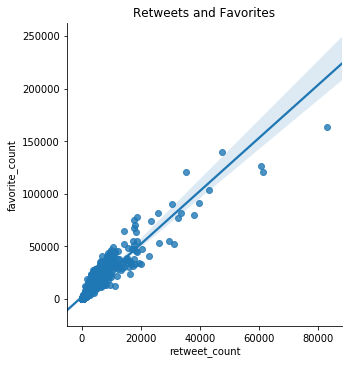

In [398]:
# Plot number of retweets agains number of favorites
sns.lmplot(x='retweet_count', y='favorite_count', data=archive)
ax = plt.gca()
ax.set_title('Retweets and Favorites');

In [399]:
# Print correlation coefficient for retweets and favorites
print(np.corrcoef(archive['retweet_count'], archive['favorite_count']))

[[1.         0.92978349]
 [0.92978349 1.        ]]


>Favorites and retweets have a very strong positive correlation (0.93). It makes logical sense: when a person enjoys a tweet, they're probably more likely to share it with their followers.

### 3. Do humans care about mathematical integrity?

##### Rating ratios and tweet performance

In [400]:
# Create new series with the ratio of numerator to denominator
# Create new series summing retweet and favorite count for each tweet
archive['rate_prop'] = archive['rating_numerator'] / archive['rating_denominator']
archive['rt_fav_total'] = archive['retweet_count'] + archive['favorite_count']

In [401]:
# Check sizes of sub-samples
len(archive[archive['rate_prop'] > 1]), len(archive[archive['rate_prop'] <= 1])

(1137, 831)

##### Set up hypothesis test and bootstrapping
I'm interested in studying whether the average number of positive reactions for ratings > 1 is greater than the average number of positive reactions for ratings <= 1. This will form my null and alternative hypotheses, stated below. A "positive action" is an action taken by a twitter user intended to share or show appreciation of post (a favorite or a retweet. Granted, a retweet does not necessily imply appreciation, but given the light-hearted nature of this account, I'm lumping both actions into a positive category.

$\mu_{G1}, \mu_{LE1}$: average number of positive reactions for tweets with rating > 1, tweets with rating <= 1, respectively



**$H_{0}: \mu_{G1} - \mu_{LE1} \leq 0$**  (tweets with ratings > 1 earn a smaller or equal number of + reactions on average)

**$H_{1}: \mu_{G1} - \mu_{LE1} > 0$**  (tweets with ratings > 1 earn a greater number of + reactions on average)

In [402]:
# Simplify archive to minimize load
df = archive[['retweet_count', 'favorite_count', 'rt_fav_total', 'rate_prop']]
df.head()

,retweet_count,favorite_count,rt_fav_total,rate_prop
0,8231,37782,46013,1.3
1,6083,32454,38537,1.3
2,4026,24436,28462,1.2
3,8389,41114,49503,1.3
4,9088,39322,48410,1.2


In [403]:
# Get average number of positive reactions for each group
obs_G1_mean = df.query('rate_prop > 1').rt_fav_total.mean()
obs_LE1_mean = df.query('rate_prop <= 1').rt_fav_total.mean()

# Display average positive reactions
round(obs_G1_mean,1), round(obs_LE1_mean,1)


(16327.4, 4551.2)

In [404]:
# Store and display observed difference in averages
obs_mean_diff = obs_G1_mean - obs_LE1_mean
round(obs_mean_diff,1)

11776.1

In [405]:
# Create a sampling distribution of the difference in means using bootstrapping method
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    G1_mean = b_samp.query('rate_prop > 1').rt_fav_total.mean()
    LE1_mean = b_samp.query('rate_prop <= 1').rt_fav_total.mean()
    diffs.append(G1_mean - LE1_mean)

In [406]:
# Convert to numpy array
diffs = np.array(diffs)

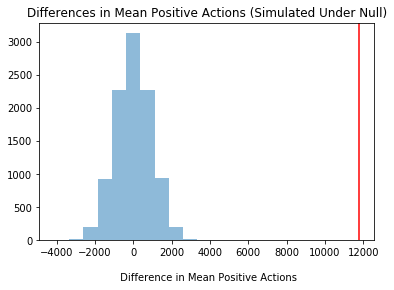

In [407]:
# Histogram simulated under the null hypothesis plotted with the observed difference
plt.hist(null_vals, alpha=0.5)
plt.title("Differences in Mean Positive Actions (Simulated Under Null)")
plt.xlabel("\n Difference in Mean Positive Actions")
plt.axvline(obs_mean_diff, color='red');

In [408]:
# Compute p-value
(null_vals > obs_mean_diff).mean()

0.0

> We have evidence, with a 0.05 p-value, to reject the null hypothesis that tweets with rating ratios greater than 1 earn a smaller or equal number of + reactions on average when compared to tweets with rating ratios less than or equal to 1.

### 4. Image predictions

##### Cats or dogs
A little exploration revealed that sometimes the algorithm thinks that the animal in the image is a type of cat, inlcuding Polecat, Cat, Lion, Tiger, Tiger Cat, Egyptian Cat, Madagascar Cat, Persian Cat, or Siamese Cat.

In [409]:
felines = ['Polecat', 'Cat', 'Lion', 'Tiger', 
           'Tiger Cat', 'Egyptian Cat', 'Madagascar Cat', 'Persian Cat', 'Siamese Cat']
cat_preds = predictions[predictions['prediction'].isin(felines)]


In [410]:
cat_preds

,tweet_id,jpg_url,img_num,order,prediction,confidence,accuracy
598,669661792646373376,https://pbs.twimg.com/media/CUsd2TfWwAAmdjb.jpg,1,2,Siamese Cat,0.148263,False
761,670727704916926465,https://pbs.twimg.com/media/CU7nSZEW4AA6r5u.jpg,1,3,Egyptian Cat,0.154914,False
823,670833812859932673,https://pbs.twimg.com/media/CU9HyzSWIAAVcte.jpg,1,2,Persian Cat,0.265442,False
892,671390180817915904,https://pbs.twimg.com/media/CVFBzpXVEAAHIOv.jpg,1,2,Tiger,0.000837,False
1037,672272411274932228,https://pbs.twimg.com/media/CVRkLuJWUAAhhYp.jpg,2,3,Siamese Cat,0.009221,False
1056,672538107540070400,https://pbs.twimg.com/media/CVVV1wJWoAEcOyk.jpg,1,1,Siamese Cat,0.383937,False
1222,673709992831262724,https://pbs.twimg.com/media/CVl_qbjW4AA8Mam.jpg,1,2,Siamese Cat,0.181580,False
1253,674024893172875264,https://pbs.twimg.com/media/CVqeEKLW4AA1wXH.jpg,1,3,Persian Cat,0.006448,False
1370,674774481756377088,https://pbs.twimg.com/media/CV1HztsWoAAuZwo.jpg,1,3,Siamese Cat,0.227677,False
1606,676942428000112642,https://pbs.twimg.com/media/CWT7imQXIAMwpQ2.jpg,1,2,Polecat,0.154630,False


In [411]:
# Check to see if any of the cat predictions are for the same tweet
cat_preds.duplicated(subset='tweet_id').sum()

0

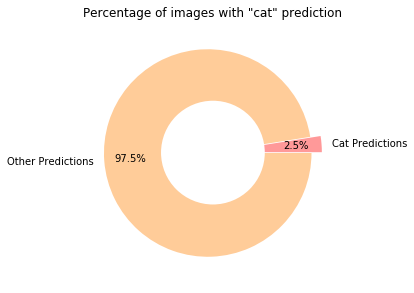

In [412]:
# Donut chart
labels = ['Cat Predictions',  'Other Predictions']
sizes = [len(cat_preds), (len(predictions)/3) - len(cat_preds)]
# Colors
colors = ['#ff9999','#ffcc99']
# Explosion
explode = (0.05,0.05)
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=0, pctdistance=0.75, explode = explode)
# Draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.title('Percentage of images with "cat" prediction')
plt.show()

>2.5 percent of these photos are being recognized as cats by the image algorithm. 

Resource: [A better visualization of pie charts](https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f)

### 5. Account reach over time

##### Rolling averages of RTs and favorites
How is the account reach and popularity changing over time? In order to calculate this, I'll look at rolling averages of retweets and favorite counts.

In [413]:
# Create new df with RT and favorite count totals grouped by week to get consistent date window
week_data = archive.groupby(pd.Grouper(key='timestamp', freq='1w'))\
            [['retweet_count', 'favorite_count']].sum().reset_index().sort_values('timestamp')[:-1]

In [414]:
# Set the date as the index so graphing works
week_data.set_index('timestamp', inplace=True)
week_data.head()

,retweet_count,favorite_count
timestamp,,
2015-11-15,587,2770
2015-11-22,69520,163126
2015-11-29,75423,180566
2015-12-06,91935,198306
2015-12-13,105150,261222


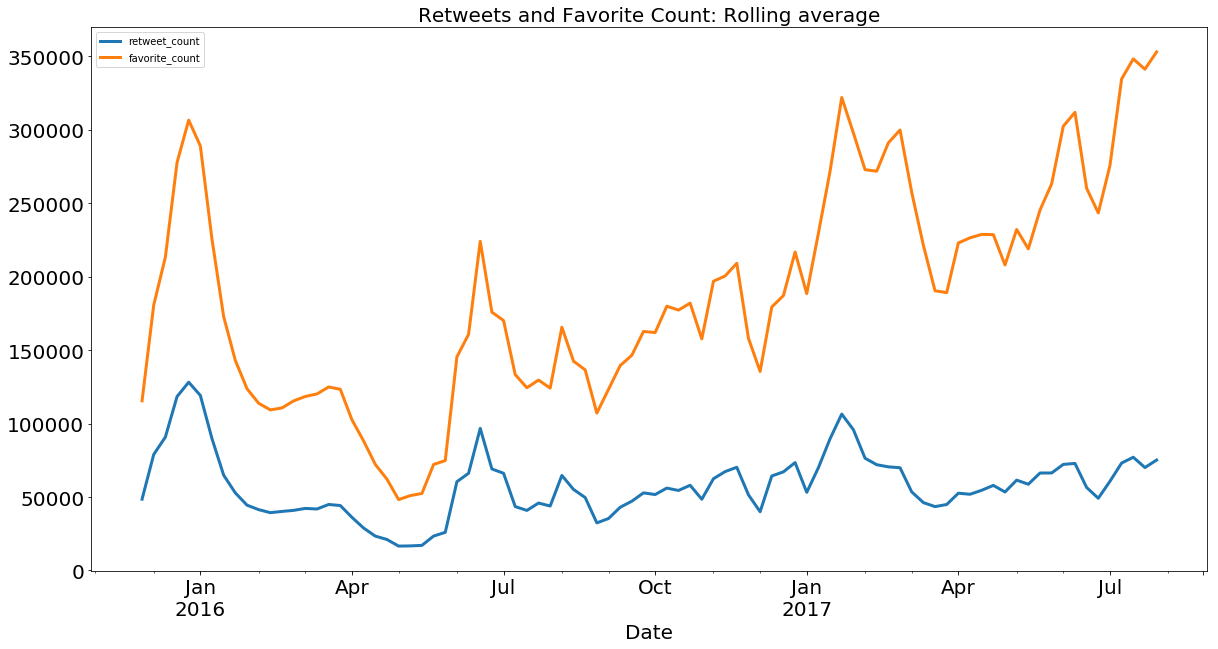

In [415]:
# Plot rolling average
df_roll = pd.concat([week_data['retweet_count'].rolling(3).mean(), week_data['favorite_count'].rolling(3).mean()], axis=1)
df_roll.plot(figsize=(20,10), linewidth=3, fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Retweets and Favorite Count: Rolling average', fontsize=20);

>Favorite count is increasing over time and retweet count is remaining relatively steady.

Resources: [Grouper](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html); [Date functionality](http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)